In [ ]:
!pip install graphviz #installing the library for trees visualization
!pip install pydotplus #installing the library for tree visualization too
!pip install category_encoders #installing the library for tree visualization also

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 731 kB/s 


In [ ]:
import pandas as pd #import pandas to manipulate DataFrame
import numpy as np #import numpy for mathematical functions
import matplotlib.pyplot as plt #import matplotlib for visualization
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from category_encoders import OrdinalEncoder #import encoder for the target variable
from sklearn import tree #importing tree for classification
from sklearn.metrics import confusion_matrix #importing confusion matrix in order to get metrics about the results
from sklearn import metrics #getting the metrics library to compare the different models
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve #importing the differents metrics for comparaison
from sklearn.model_selection import cross_val_score #function for cross validation scores
from sklearn.metrics import f1_score #function that compute the f1 score
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline #module to create the pipeline to test the different hyperparameters
from sklearn.model_selection import GridSearchCV #tool in order to detect the best model by testing the different options
from sklearn.metrics import f1_score, make_scorer

# Import des données et visualisation du jeu de données

Commençons par importer le dataset à l'aide de pandas

In [ ]:
df=pd.read_csv('/content/pb3_table.csv', sep=',') #reading the csv to import content

In [ ]:
df=df.drop(columns=df.columns[0]) #erasing the index column in order to avoid problems in the future
print(df) #visulaizing the result

    nativeSpeaker  age   shoeSize      score
0             yes    5  24.831889  32.293850
1             yes    6  25.952378  36.631049
2              no   11  30.421700  49.605927
3             yes    7  28.664501  40.284556
4             yes   11  31.882070  55.460851
..            ...  ...        ...        ...
195            no    8  26.447560  37.548872
196           yes    5  23.983696  32.170169
197           yes    7  27.945321  40.381101
198            no    7  26.898883  33.636685
199            no    8  26.706719  38.685425

[200 rows x 4 columns]


une fois le dataset importé, nous pouvons commencer par visualiser les données en fonction de leurs types, informations générales et répartitions :

In [ ]:
print(df.head(),df.tail()) #displaying the first information of the dataframe
print(df.describe()) #visualizing the basic information about the dataset
repartvar=df['nativeSpeaker'].loc[df['nativeSpeaker'] == 'no'].value_counts()[0]/(df['nativeSpeaker'].loc[df['nativeSpeaker'] == 'yes'].value_counts()[0]+df['nativeSpeaker'].loc[df['nativeSpeaker'] == 'no'].value_counts()[0])
print('Here is the shape of our Data frame ' '' + str(df.shape)+ '') #printing the shape of the Data Frame
print('Here is the repartition for our target variables in our Data frame ' '' + str(repartvar)+ '') #printing the repartition for targer variable of the Data Frame
print(df.info()) #printing information about the different columns of the dataset

  nativeSpeaker  age   shoeSize      score
0           yes    5  24.831889  32.293850
1           yes    6  25.952378  36.631049
2            no   11  30.421700  49.605927
3           yes    7  28.664501  40.284556
4           yes   11  31.882070  55.460851     nativeSpeaker  age   shoeSize      score
195            no    8  26.447560  37.548872
196           yes    5  23.983696  32.170169
197           yes    7  27.945321  40.381101
198            no    7  26.898883  33.636685
199            no    8  26.706719  38.685425
              age    shoeSize       score
count  200.000000  200.000000  200.000000
mean     7.925000   27.869762   40.662402
std      1.886044    2.041288    8.531805
min      5.000000   23.173425   25.262491
25%      6.000000   26.233330   33.937146
50%      8.000000   27.852683   40.332828
75%      9.250000   29.490390   47.573671
max     11.000000   32.327787   56.711508
Here is the shape of our Data frame (200, 4)
Here is the repartition for our target variables 

On peut déduire plusieurs choses de ces informations:

1) notre Dataset est balancé ce qui sera arrangeant pour la suite en effet cela signifie que notre variable cible est équitablement répartie selon yes ou no, il faudra bien penser à conserver cette information lors du split en training test et testing set

2) on voit que le type de notre variable d'arrivée est encodée en objet, il nous faut donc la convertir dans un format plus adpaté pour notre entrainement, nous allons donc procéder à l'encodage de la variable dans la cellule suivant avec un encodage des yes en 1 et no en 0. 

3) toute nos données sont des entiers ou des nombres flottants. ce qui ne nous permettra donc pas d'appliquer des arbres de décision de type IDC3 mais uniquement des CART.

4) la plupart des individus sont des enfants avec une variabilité dans le score beaucoup plus importantes que sur les autres colonnes.

reprenons l'analyse rapide en traçant les différentes répartitions suivant les variables et en encodant notre target variable.


In [ ]:
mapping = [{'col': 'nativeSpeaker', 'mapping': {"yes": 1,  "no": 0,}}] #setting the dictionnary in order to encode our target variables
df=OrdinalEncoder(cols=['nativeSpeaker'], mapping=mapping).fit(df).transform(df) #encoding with the dictionnary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   nativeSpeaker  200 non-null    int64  
 1   age            200 non-null    int64  
 2   shoeSize       200 non-null    float64
 3   score          200 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 6.4 KB
None


On a donc bien reussi l'encodage de notre variable !

In [ ]:
L=df.columns.to_list() #takings all the different columns name
def histo(column): #creating the function for the histogram
  plt.hist(df[column],bins=10) #plotting the histogram with the intervals divided into 50 equal size bins
  plt.title(column) #setting up the title as the name of the column
  plt.xlabel(' Values of the occurences ' + str(column)+ '') #setting xlabels
  plt.ylabel("Number of occurences in the dataset") #setting y labels
  plt.savefig('Histogram of : ' +str(column), dpi=300) #saving the figures
  plt.show() #printing the different figures

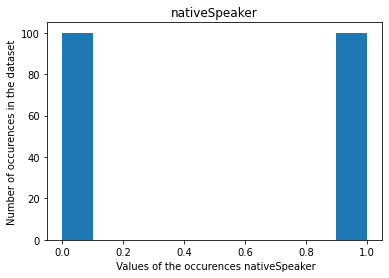

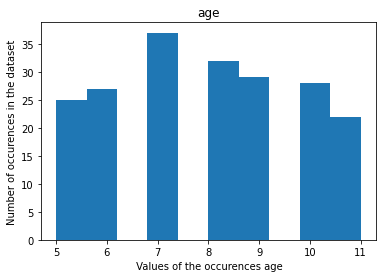

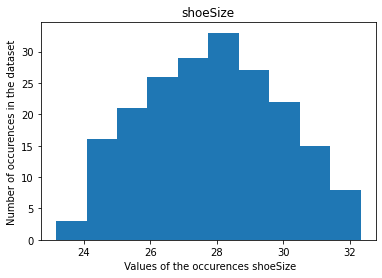

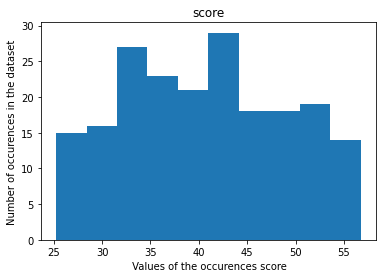

In [ ]:
for i in L:  #creating a list with all the columns
  histo(i) #boxplotting the different columns

On retrouve bien ici sur le premier graphique le caractère balancé du dataset, le deuxième graphe n'est pas tout à fait interprétable car les valeurs sont des entiers et la definition de notre fonction ne permet pas de bien visualiser la répartition. Le 3ème graphe nous permet de voir que la répartition de taille de chaussures peut s'apparenter à une distribution normale. Enfin le score semble ne pas avoir de caractéristiques spécifiques concernant sa répatition. 

# Visualsation des corrélations

Maintenant que l'on voit un peu mieux comment se comporte chaque variable, nous allons nous intéresser aux intéractions entre les différentes variables, nottament via l'analyse des différentes corrélations entres ces dernières. on va donc regarder la correlation des différentes variables suivant notre variable cible (Target variable)

In [ ]:
df.corr() #computing the correlation matrix of the different variables

,nativeSpeaker,age,shoeSize,score
nativeSpeaker,1.000000,0.135543,0.095885,0.471515
age,0.135543,1.000000,0.896934,0.935527
shoeSize,0.095885,0.896934,1.000000,0.831575
score,0.471515,0.935527,0.831575,1.000000


In [ ]:
corre=df.corr().iloc[0].sort_values(ascending=False)[1:] #selecting the class row and display the values by descending order
print(corre) #printing it

score       0.471515
age         0.135543
shoeSize    0.095885
Name: nativeSpeaker, dtype: float64


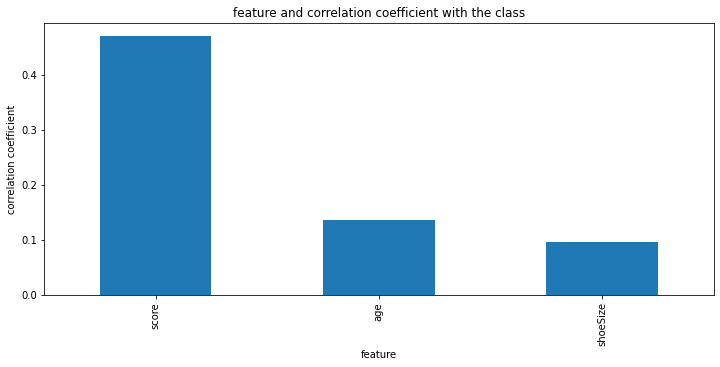

In [ ]:
plt.figure(figsize=(12, 5)) #setting the figure size
labels = [f"{i}" for i in corre.index.to_list()] #extracting the different label
ax = corre.plot(kind="bar") #ploting the different bars
ax.set_title("feature and correlation coefficient with the class") #setting the tittle
ax.set_xlabel("feature") #setting de x labels
ax.set_ylabel("correlation coefficient") #setting the y label
ax.set_xticklabels(labels) # setting the x ticks labels
plt.savefig('Feature and correlation coefficient for class',dpi=300) #saving the figure
plt.show() #showing the graph

On observe donc une correlation très importante entre la variable prédite et le score obtenu par l'enfant, cette correlation est bien plus significative que la correlation avec les autres variables.

# Préparation de l'entrainement

Maintenant que nous savons un peu plus quelles sont nos données et comment elles se comportent, nous pouvons préparer la creation d'un classifier qui s'appuierait sur ces dernières, on va donc commencer par séparer notre jeu de données en essayant de conserver les caractéristiques propres de notre dataset (nottament la répartition de 0 et 1 suivant notre variable cible. notre training set et testing set seront donc balancé). afin de valider au mieux notre modèle dans le futur, on va également creer un training set et un testing set avec un rapport 70/30 afin d'éviter tout risque de biais supplémentaires suite à l'apprentissage. 

In [ ]:
dfexp=df.copy() #creating a copy of the dataframe
yexp=dfexp['nativeSpeaker'] #selecting the target variables
xexp=dfexp.drop(['nativeSpeaker'],axis=1) #selecting the features only
# Split dataset into training set and test set

X_train,X_test,y_train,y_test= train_test_split(xexp,yexp,test_size=0.3, random_state=42, shuffle=True, stratify=df['nativeSpeaker']) #splitting into different values in order to go quicker in the computation selecting only 30% of the data

print(y_test)

print("Here is the proportion of positive on the target variable in the testing set " +str(y_test.value_counts()[1]/(y_test.value_counts()[1]+y_test.value_counts()[0])) +'')
print("Here is the proportion of positive on the target variable in the training set " +str(y_train.value_counts()[1]/(y_train.value_counts()[1]+y_train.value_counts()[0])) +'')


print(X_train,y_train) #printing training data 
print(X_test,y_test) #printing testing data


10     1
32     0
8      1
70     1
64     1
123    1
93     0
26     1
180    0
156    1
27     1
77     1
198    0
23     1
129    0
9      0
0      1
114    0
118    0
39     1
191    1
3      1
49     1
6      0
151    1
52     0
166    0
103    0
104    0
62     0
67     0
157    0
170    0
145    0
78     0
60     1
43     0
187    1
194    1
181    0
96     1
190    0
48     1
161    1
47     0
119    0
5      1
88     1
140    0
82     0
169    0
144    0
189    1
11     1
149    1
164    0
97     1
127    1
116    0
65     1
Name: nativeSpeaker, dtype: int64
Here is the proportion of positive on the target variable in the testing set 0.5
Here is the proportion of positive on the target variable in the training set 0.5
     age   shoeSize      score
2     11  30.421700  49.605927
98     7  27.600339  40.010644
85     9  30.082341  48.724012
162    5  26.625961  25.745932
179    7  26.922794  40.200016
..   ...        ...        ...
136    6  25.209197  30.640974
40     5  26.23

# Séléction des modèles les plus performants avant une analyse plus pousée

Afin d'avoir le modèle le plus optimal possible, nous allons utiliser un algorithme de Grid search afin de pouvoir entrainer différents modèles et comparer leurs scores avant de comparer les meilleurs d'entre eux. 

On va donc entrainer différents arbres de décision avec des paramètres que l'on aura choisi et on comparera leurs scores.

on va donc essayer :

1) différentes fonctions pour l'impureté de notre arbre (Gini, Entropy)

2) différentes profondeurs  pour notre arbre (de 1 à 4 comme profondeur maximale)

3) différentes feuilles minimums d'échantillonage pour  transformer un noeud en feuille lorsqu'il y a trop peu de données après ce dernier. On fera varier ce paramètres de 1 à 8.

4) différentes impuretés minimales afin d'appliquer un prunning de notre arbre 

On va donc créer une pipeline qui va nous permettre de créer les différents modèles suivant un dictionnaire de paramètres que l'on va créer, la fonction grid search va ensuite s'occuper d'itérer sur tous les modèles les entrainements, les crossvalidations et les calculs de différents score avant de nous renvoyer toutes les informations concernant les différents modèles et nous permettre de choisir les plus performants d'un point de vue du score ! En tant que score nous prendrons principalement un score classique ! On fera également un gridsearch avec un score différent le F1 afin d'avoir un deuxième modèle avec lequel on pourra le comparer

# Gridsearch avec un Score classique

In [ ]:
dec_tree = tree.DecisionTreeClassifier(random_state=42) #creating the kind of model on wich we want to test the hyperparameters

In [ ]:
pipe = Pipeline(steps=[('dec_tree', dec_tree)]) #setting up the pipeline

criterion = ['gini', 'entropy'] #choosing the different criterions
max_depth = [i for i in range(1,5)] #choosing the depth we want to test
min_samples_leaf = [i for i in range(1,8)] #setting up the minimum sample in a leaf
min_impurity_decrease = [i/10000 for i in range(0,10)] #setting up the different minimum impurity value for pruning
parameters = dict(dec_tree__criterion=criterion,dec_tree__max_depth=max_depth,dec_tree__min_samples_leaf=min_samples_leaf,dec_tree__min_impurity_decrease=min_impurity_decrease) #setting up the dictionnary with all the parameters choosen

clf_GS = GridSearchCV(pipe, parameters) #using grid search on the pipe with our parameters
clf_GS.fit(X_train,y_train) #fitting all the different models of the pipeline
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion']) #printing the best criterion for impurety for the best model
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth']) #printing the best depth for the best model
print('Best min_sample_leaf:', clf_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf']) #printing the best min sample leaf for the best model
print('Best min_impurity decrease:', clf_GS.best_estimator_.get_params()['dec_tree__min_impurity_decrease']) #printing the best min sample leaf for the best model
print(); print(clf_GS.best_estimator_.get_params()['dec_tree']) #printing the best estimator

Best Criterion: gini
Best max_depth: 3
Best min_sample_leaf: 3
Best min_impurity decrease: 0.0

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=42)


# Gridserach avec le F1 score

In [ ]:
f1 = make_scorer(f1_score, average = 'macro') #creating a scorer on F1 in order to use it as a scoring method

In [ ]:
clf_GS2 = GridSearchCV(pipe, parameters,scoring=f1) #using grid search on the pipe with our parameters
clf_GS2.fit(X_train,y_train) #fitting all the different models of the pipeline
print('Best Criterion:', clf_GS2.best_estimator_.get_params()['dec_tree__criterion']) #printing the best criterion for impurety for the best model
print('Best max_depth:', clf_GS2.best_estimator_.get_params()['dec_tree__max_depth']) #printing the best depth for the best model
print('Best min_sample_leaf:', clf_GS2.best_estimator_.get_params()['dec_tree__min_samples_leaf']) #printing the best min sample leaf for the best model
print('Best min_impurity decrease:', clf_GS2.best_estimator_.get_params()['dec_tree__min_impurity_decrease']) #printing the best min sample leaf for the best model
print(); print(clf_GS2.best_estimator_.get_params()['dec_tree']) #printing the best estimator

Best Criterion: gini
Best max_depth: 3
Best min_sample_leaf: 3
Best min_impurity decrease: 0.0

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=42)


On va donc récuperer les paramètres de ces 2 classifier avec des scorer différents afin de les exploiter pour notre modélisation et les comparer

In [ ]:
Estimator1 = np.where(clf_GS.cv_results_['rank_test_score']==1)[0][0] #getting the index of the best estimator based on classic score
criterionpara1,maxdepthpara1,minsampleleafpara1,minimpurity1=clf_GS.cv_results_['param_dec_tree__criterion'][int(Estimator1)],clf_GS.cv_results_['param_dec_tree__max_depth'][int(Estimator1)],clf_GS.cv_results_['param_dec_tree__min_samples_leaf'][int(Estimator1)],clf_GS.cv_results_['param_dec_tree__min_impurity_decrease'][int(Estimator1)]#getting all the parameters of the best estimator
print(criterionpara1,maxdepthpara1,minsampleleafpara1,minimpurity1) #printing the different parameters of the best estimator

gini 3 3 0.0


In [ ]:
Estimator2 = np.where(clf_GS2.cv_results_['rank_test_score']==1)[0][0] #getting the index of the best estimator based on f1 score
criterionpara2,maxdepthpara2,minsampleleafpara2,minimpurity2=clf_GS2.cv_results_['param_dec_tree__criterion'][int(Estimator2)],clf_GS2.cv_results_['param_dec_tree__max_depth'][int(Estimator2)],clf_GS2.cv_results_['param_dec_tree__min_samples_leaf'][int(Estimator2)],clf_GS2.cv_results_['param_dec_tree__min_impurity_decrease'][int(Estimator2)] #getting all the parameters of the second best estimator
print(criterionpara2,maxdepthpara2,minsampleleafpara2,minimpurity2) #printing the different parameters of the second best estimator

gini 3 3 0.0


Nos deux estimateurs ont les mêmes paramètres, notre modèle semble donc converger vers ce dernier, nous choisirons donc un modèle arbitraire par la suite pour le classifier 2

# Création des classifier, entrainement et visualisation

on a donc séléctionner nos paramètres, nous allons donc entrainer nos modèles avec notre training set, on va également effectuer les prédictions pour notre testing set afin de pouvoir réexploiter ces prédictions dans la vérifications de notre modèle. Nous allons ensuite visualiser les différents arbres avec deux méthodes sous python qui sont toutes les deux équivalentes

In [ ]:
clf1 = DecisionTreeClassifier(criterion=criterionpara1,max_depth=maxdepthpara1,min_samples_leaf=minsampleleafpara1,min_impurity_decrease=minimpurity1,random_state=42) #creating the first classifier
clf1.fit(X_train, y_train) #fitting the first classifier
ypredtest1=clf1.predict(X_test) #predicting the testing data with the first classifier

clf1 = RandomForest(criterion=criterionpara1,max_depth=maxdepthpara1,min_samples_leaf=minsampleleafpara1,min_impurity_decrease=minimpurity1,random_state=42) #creating the first classifier
clf1.fit(X_train, y_train) #fitting the first classifier
ypredtest1=clf1.predict(X_test) #predicting the testing data with the first classifier

clf2 = DecisionTreeClassifier(criterion='entropy',max_depth=3,min_samples_leaf=minsampleleafpara2,min_impurity_decrease=minimpurity2,random_state=42) #creating the second classifier
clf2.fit(X_train, y_train) #fitting the second classifier
ypredtest2=clf2.predict(X_test) #predicting the testing data with the second classifier

NameError: ignored

# Visualisation des arbres



In [ ]:
!pip install --upgrade scikit-learn==0.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 5.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22 which is incompatible.


In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


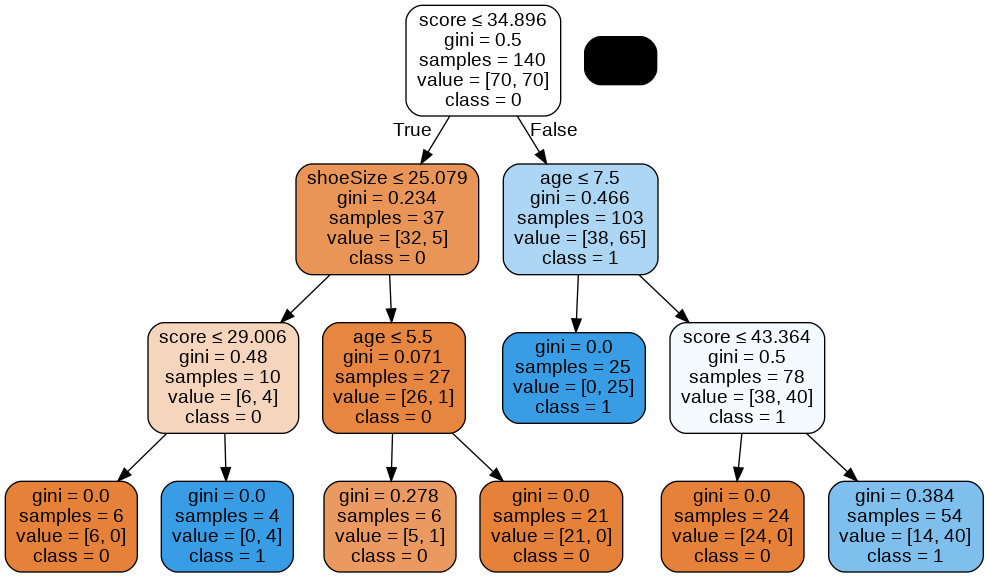

In [ ]:
dot_data = StringIO()
export_graphviz(clf1, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = X_train.columns.to_list(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Clf1 Nativespeaker tree.png')
Image(graph.create_png())

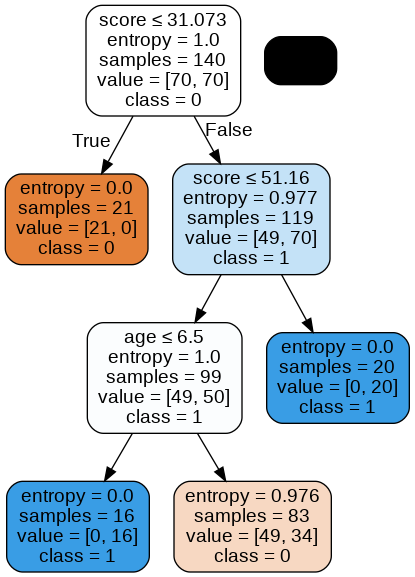

In [ ]:
dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data,filled=True, rounded=True,special_characters=True,feature_names = X_train.columns.to_list(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Clf2 Nativespeaker tree.png')
Image(graph.create_png())

# Calcul des scores, Cross validation et métriques de comparaison

Afin de déterminer le meilleur modèle parmis nos différentes tentatives d'entrainement, nous allons utiliser différentes métriques pour les comparer, ces métriques seront calculées sur le testing set et ont pour but de comparer les différentes performances des modèles. Nous allons donc nous intéresser aux aspects suivants : 

1) la précision du modèle, elle nous permet de dégager une idée générale sur la précision de notre modèle, cependant elle ne prend pas forcément en compte tous les paramètres, nottament la classe sur laquelle il y a le plus d'erreur ou d'autres paramètres

2) La précision moyenne des cross validation, nous allons effectuer 3 étapes de cross validation et comparer les valeurs moyennes et la variance des score obtenus par chaque modèle. Cela nous permet de quantifier la robustesse de notre modèle et sa précision.

3) Les matrices de confusion des modèles, ces matrices nous permettent d'évaluer les prédictions en prenant en compte le taux de faux négatif, faux positif, vrai négatif et vrai positif, ainsi on a une vision plus locale des performances des modèles en fonction de nos prédictions et de leurs classes. Dans le cas d'une application médicale, cela semble plutot pertinent de prendre en compte ces facteurs car on va avoir tendance à réduire dans notre situation le taux de faux négatif au maximum et augmenter le taux de vrai positif car les patients ont besoin d'être pris en charge au plus vite et donc il ne faut pas rater la classification par rapport à ces aspects.

4) Les F1 score des différents modèles est un métrique qui permet de connaitre la fiabilité à bien prédire les individus positif. Ainsi nous allons chercher à maximiser ce score

5) les courbes ROC/AUC

6) les taux de bonnes prédictions en fonction des classes

7) Le recall

In [ ]:
clf1score=clf1.score(X_test, y_test) #computing the score for classifier 1
clf2score=clf2.score(X_test, y_test) #computing the score for classifier 1

In [ ]:
scoresclf1 = cross_val_score(clf1, X_train, y_train, cv=10) #computing the cross validations score for classifier 1
scoresclf2 = cross_val_score(clf2, X_train, y_train, cv=10) #computing the cross validations score for classifier 2
print(" for classifier 1, %0.2f is the accuracy with a standard deviation of %0.2f" % (scoresclf1.mean(), scoresclf1.std())) #printing the values of cross val score for classifier 1
print(" for classifier 2, %0.2f is the accuracy with a standard deviation of %0.2f" % (scoresclf2.mean(), scoresclf2.std())) #printing the values of cross val score for classifier 2
matrix1=confusion_matrix(y_test, ypredtest1) #computing confusion matrix for clf1
matrix2=confusion_matrix(y_test, ypredtest2) #computing confusion matrix for clf2

 for classifier 1, 0.84 is the accuracy with a standard deviation of 0.10
 for classifier 2, 0.75 is the accuracy with a standard deviation of 0.08


In [ ]:
TN1,FP1,FN1,TP1 = matrix1[1][1],matrix1[0][1],matrix1[1][0],matrix1[0][0]  #getting confusion matrix values for clf1
classerror11,classerror01,FNrate1,TPrate1=FP1/(TP1+FP1),TN1/(TN1+FN1),FP1/np.sum(matrix1),TP1/np.sum(matrix1) #computing different metrics for clf1
print('True Positive', TP1)
print('True Negative', TN1)
print('False Positive', FP1)
print('False Negative', FN1)
TN2,FP2,FN2,TP2= matrix2[1][1],matrix2[0][1],matrix2[1][0],matrix2[0][0] #getting confusion matrix values for clf1
print('True Positive', TP2)
print('True Negative', TN2)
print('False Positive', FP2)
print('False Negative', FN2)
classerror12,classerror02,FNrate2,TPrate2=FP2/(TP2+FP2),TN2/(TN2+FN2),FP2/np.sum(matrix2),TP2/np.sum(matrix2) #computing the different rates for clf2


True Positive 25
True Negative 28
False Positive 5
False Negative 2
True Positive 29
True Negative 15
False Positive 1
False Negative 15


In [ ]:
F1score1=f1_score(y_test, ypredtest1) #computing F1 score for clf1
F1score2=f1_score(y_test, ypredtest2) #computing F1 score for clf2

In [ ]:
y_score1 = clf1.predict_proba(X_test)[:, 1]
y_score2 = clf2.predict_proba(X_test)[:, 1]
average_precision1 = average_precision_score(y_test, y_score1) 
average_precision2 = average_precision_score(y_test, y_score2)
print(average_precision1,average_precision2)

0.8552489177489178 0.7572115384615384


In [ ]:
from sklearn.metrics import precision_score, recall_score

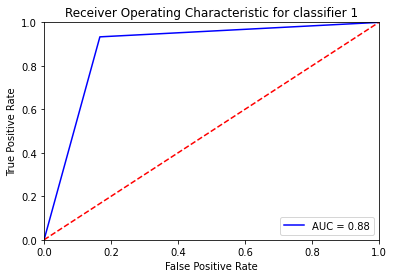

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf1.predict_proba(X_test)
preds = ypredtest1
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc1 = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for classifier 1')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC classifier 1.png")
plt.show()

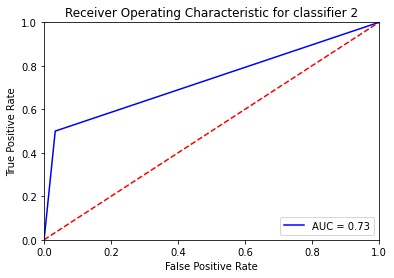

In [ ]:
probs = clf2.predict_proba(X_test)
preds = ypredtest2
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc2 = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic for classifier 2')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC classifier 2")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


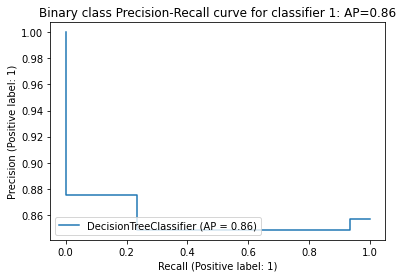

In [ ]:
disp = plot_precision_recall_curve(clf1, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve for classifier 1: '
                   'AP={0:0.2f}'.format(average_precision1))

precision, recall, thresholds = precision_recall_curve(y_test, y_score1)
auc_precision_recall = auc(recall,precision)
recall=recall_score(y_test, ypredtest1)
precision=precision_score(y_test, ypredtest1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


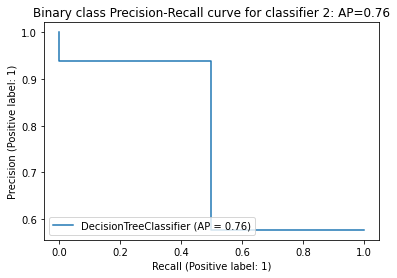

In [ ]:
disp = plot_precision_recall_curve(clf2, X_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve for classifier 2: '
                   'AP={0:0.2f}'.format(average_precision2))

precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_score2)
auc_precision_recall2 = auc(recall2, precision2)
recall2=recall_score(y_test, ypredtest2)
precision2=precision_score(y_test, ypredtest2)

# Création du DataFrame final pour comparaison

Afin de pouvoir comparer les différents modèles, nous allons utiliser le dataframe compilant toutes les informations nescessaires à la comparaison. Pour faire cela nous allons représenter graphiquement les différentes valeurs et comparer les différentes informations. Avant cela nous allons sauvegarder les différents résultats dans un fichier csv. 

In [ ]:
datacompare = {'Score':[clf1score,clf2score], 'Cross Validation mean':[scoresclf1.mean(),scoresclf2.mean()],'Cross Validation standard deviation':[scoresclf1.std(),scoresclf2.std()],'ROC-AUC':[roc_auc1,roc_auc2],'F1 score':[F1score1,F1score2], 'Confusion Matrix':[matrix1,matrix2],'True positive':[TP1,TP2],'True positive rate ':[TPrate1,TPrate2], 'False positive':[FP1,FP2],'True negative':[TN1,TN2],'False negative':[FN1,FN2],'False negative rate ':[FNrate1,FNrate2],'Class error on 0 class':[classerror01,classerror02],'Class error on 1 class':[classerror11,classerror12], 'average precision score':[average_precision1,average_precision2], 'recall':[recall,recall2], 'precision':[precision,precision2], 'auc-precision-recal':[auc_precision_recall,auc_precision_recall2]}  
  
# Creates pandas DataFrame.  
dfcompare = pd.DataFrame(datacompare, index =['Classifier 1', 'Classifier 2'])  
dfplot=dfcompare
dfcompare=dfcompare.transpose()
dfcompare

,Classifier 1,Classifier 2
Score,0.883333,0.733333
Cross Validation mean,0.835714,0.75
Cross Validation standard deviation,0.096097,0.07986
ROC-AUC,0.883333,0.733333
F1 score,0.888889,0.652174
Confusion Matrix,"[[25, 5], [2, 28]]","[[29, 1], [15, 15]]"
True positive,25,29
True positive rate,0.416667,0.483333
False positive,5,1
True negative,28,15


#Visualisation des valeurs et décision sur le modèle à conserver

Maintenant que nous avons tous les indicateurs, nous allons les analyser afin de déterminer quel est le modèle le plus adapté. 

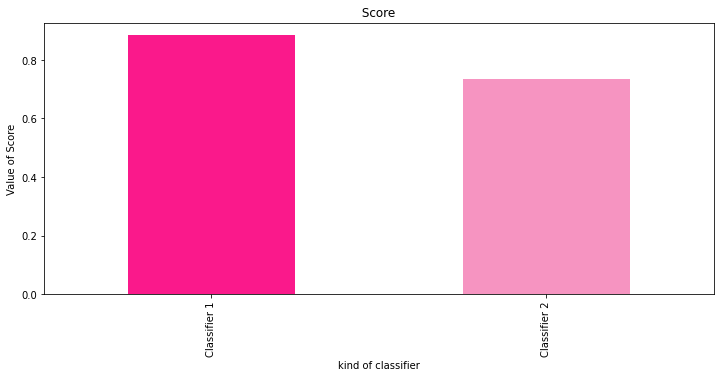

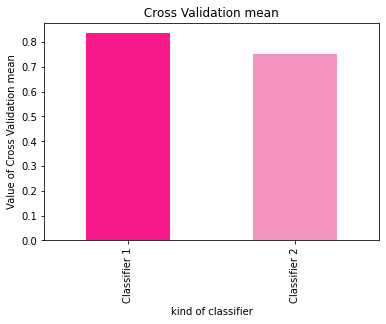

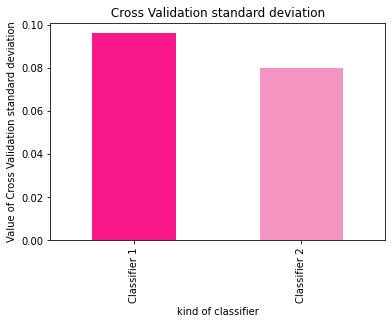

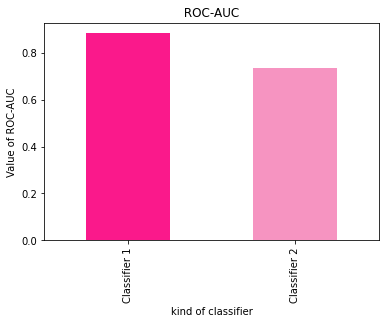

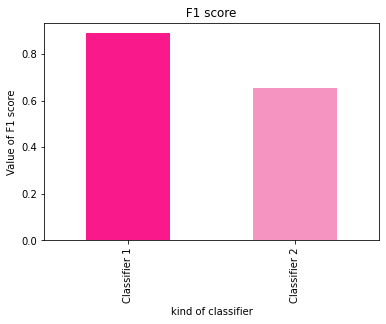

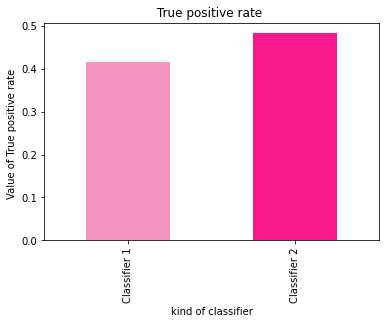

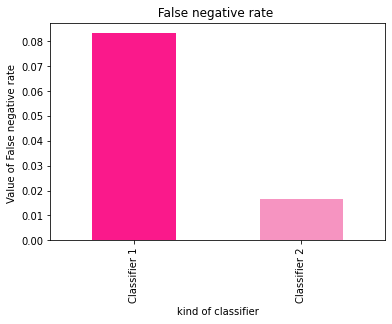

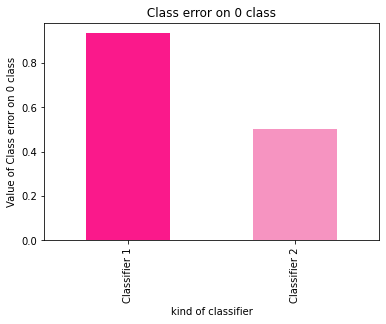

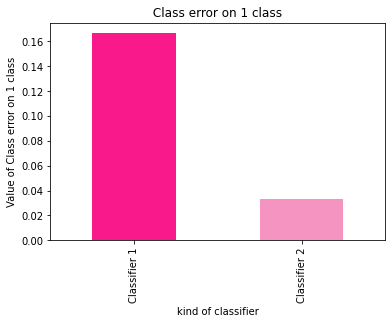

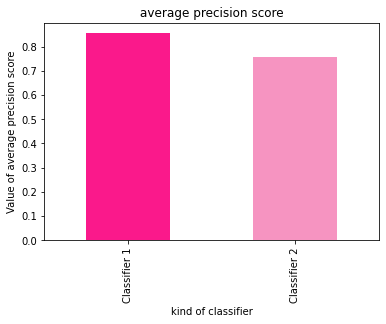

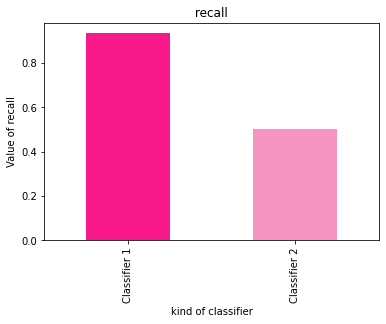

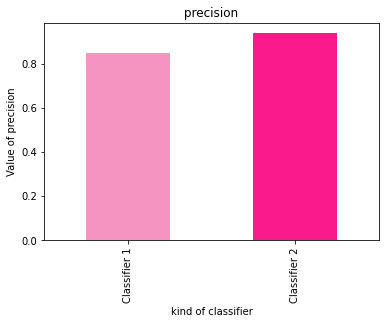

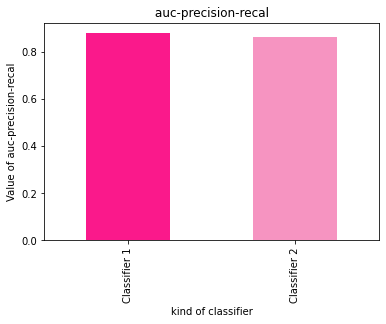

In [ ]:
plt.figure(figsize=(12, 5)) #setting the figure size
labels = [f"{i}" for i in dfplot.index.to_list()] #extracting the different label
labelscol = [f"{i}" for i in dfplot.columns.to_list()]
for i in range(0,len(labelscol)):
  if type(dfplot[labelscol[i]][1])==type(dfplot["auc-precision-recal"][1]):
    colorslab = [{min(dfplot[labelscol[i]])<p<max(dfplot[labelscol[i]]): '#D3F8E2', 
                  p>=max(dfplot[labelscol[i]]): '#FA198B',
                  p<=min(dfplot[labelscol[i]]): '#F694C1'
                  }[True] for p in dfplot[labelscol[i]]]
    ax = dfplot[labelscol[i]].plot(kind="bar",color=colorslab) #ploting the different bars
    ax.set_title(' '+ str(labelscol[i])+' ') #setting the tittle
    ax.set_xlabel("kind of classifier") #setting de x labels
    ax.set_ylabel("Value of "''+str(labelscol[i])+'') #setting the y label
    ax.set_xticklabels(labels) # setting the x ticks labels
    plt.savefig(' '+str(labelscol[i])+' ',dpi=300) #saving the figure
    plt.show() #showing the graph
  else:
    i=i
    


Ces figures nous permettent de comparer les différentes valeurs

Ainsi notre le plus performant semble être celui issu du gridsearch en effet il surperforme le modèle arbitraire que nous avons choisi.

Le F1 score car il donne les informations les plus pertinentes dans ce type de classification avec un dataset non balancé selon notre variable de prédiction. En effet le F1 score permet de prendre en compte le recall et la sensibilité qui sont les facteurs les plus importants dans ce type de classification ou l'on souhaite prédire plus de faux positifs que de faux négatifs car il vaut mieux approfondir les examens pour quelqu'un de non malade que de laisser passer quelqu'un de malade. En effet dans notre cas on va chercher le score le plus grand !

l'AUC/ROC pour prendre en compte la precision et le recall

Il n'y a donc aucune hésitation sur le modèle le plus performant nous conserverons le modèle numéro 1 !

In [ ]:
dfcompare.to_csv('/content/comparaison.csv',index=True) #Saving the Dataframe

Voici donc le modèle le plus performant et ses performances :

In [ ]:
print(clf_GS.best_estimator_.get_params()['dec_tree']) #printing the best estimator
print(dfcompare['Classifier 1'])

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=42)
Score                                            0.883333
Cross Validation mean                            0.835714
Cross Validation standard deviation              0.096097
ROC-AUC                                          0.883333
F1 score                                         0.888889
Confusion Matrix                       [[25, 5], [2, 28]]
True positive                                          25
True positive rate                               0.416667
False positive                                          5
True negative                                          28
False negative                                          2
False negative rate                              0.083333
Class error on 0 class                           0.933333
Class error on 1 class                           0.166667
average precision score                          0.855249
recall                                           0.933333

# Ce travail à été réalisé par Julien Séailles, je vous remercie pour le temps que vous avez pris pour le parcourir et espère sincèrement que ce travail vous aura plu !

[Si jamais vous souhaitez avoir accès au google collab, il est disponible juste ici : https://colab.research.google.com/drive/1LTdFHOtbDdu5Xq55c3TIVsfo3P4pTBfy?usp=sharing](https://colab.research.google.com/drive/1LTdFHOtbDdu5Xq55c3TIVsfo3P4pTBfy?usp=sharing)